## Neural Network - Pytorch

**Overview:**

An Artifical Neural Network (ANN) is comprised of multiple layers, containing an input layer, hidden layers and an output layer. Each node connects to another and has an associated weight and threshold. 

![Artifical Neural Network](image-5.png)

**Resources:**
- https://www.ibm.com/topics/neural-networks
- https://www.youtube.com/watch?v=aircAruvnKk

#### Neural Networks with torch.nn package. 

PyTorch is an open-source machine learning library, it was developled by Facebook's AI Research Lab (FAIR). A core component is tensors, these are multi-dimensional arrays. tensor operations work similar to NumPy operations. 

- **Documentation** - https://pytorch.org/docs/stable/index.html


**Typical training procedure for a neural network:**
1. Define the neural network that has some learnable parameters (or weights)
2. Iterate over a dataset of inputs
3. Process input through the network
4. Compute the loss (how far is the output from being correct)
5. Propagate gradients back into the network’s parameters
6. Update the weights of the network, typically using a simple update rule: weight = weight - learning_rate * gradient

**Resources:**
- https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.optim as optim

from torchmetrics import ROC
from sklearn.metrics import auc


In [102]:
# Store data as dataframe and display the head (from data stored in file)
column_names = ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our',
                'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order',
                'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report',
                'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you',
                'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 
                'word_freq_hp', 'word_freq_hpl', 'word_freq_george','word_freq_650', 'word_freq_lab', 'word_freq_labs',
                 'word_freq_telnet','word_freq_857', 'word_freq_data', 'word_freq_415','word_freq_85','word_freq_technology',
                'word_freq_1999', 'word_freq_parts','word_freq_pm','word_freq_direct','word_freq_cs','word_freq_meeting',
                'word_freq_original','word_freq_project','word_freq_re','word_freq_edu','word_freq_table','word_freq_conference',
                
                'char_freq_;','char_freq_(','char_freq_[','char_freq_!','char_freq_$','char_freq_#',
                
                'capital_run_length_average','capital_run_length_longest','capital_run_length_total','spam'
                ]

filepath = '/Users/ejallen/Desktop/Machine Learning Project/02_Data/spambase/spambase.data'
df_spam = pd.read_csv(filepath, header=None, names=column_names)

display(df_spam.head())

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [103]:
# split the data into training and testing
x = df_spam.drop('spam', axis=1).to_numpy()
y = df_spam.iloc[:,-1].to_numpy().ravel()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# convert data into PyTorch tensors
X_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

#### Explanation 

1. **Define the Model:** 
    - The model is defined as class which inherites from the nn.module
    - Fully connected layers (dense layers) are defined using the linear class
    - The activation function must come after the layer declaration, here we use **ReLU (rectified linear unit activation)** on the first two layers, this is because it will introduce non-linearity and avoid vanishing gradient problem and the **sigmoid function** in the output layer, this will ensure the ouput is between 0 and 1. 
    - An output between 0 and 1 makes it easier for classification later

        - The model expects rows of data with 57 variables 
        - The first hidden layer has n neurons, followed by a ReLU activation function
        - The second hidden layer has m neurons, followed by another ReLU activation function
        - The output layer has one neuron, followed by a sigmoid activation function <p> <!-- Paragraph break --></p>

2. **Training preparation:**
    - We have to define / choose a loss function and optimiser 
    - here we use a binary cross entropy for the loss function and Adam as the optimiser <p> <!-- Paragraph break --></p>

3. **Training the Model:**
    - The entire dataset is split into batches, and you pass the batches one by one into a model using a training loop. Once all batches have been exhausted, you have finished one epoch. then you start again with the same dataset. This process is then repeated
    - We use the following terminology:
        - *Epoch* - passes the entire training dataset to the model once 
        - *Batch* - one or more samples passed to the model, from which the gradient descent algorithm will be executed for one iteration
    - In the code this is implemented as nested for loops <p> <!-- Paragraph break --></p>

4. **Model Evaulation**
    - Evaulate  the model using test data 

- After these steps are done, the code moves to calculate and display a confusion matrix and ROC curve

**Resources:**
- https://machinelearningmastery.com/develop-your-first-neural-network-with-pytorch-step-by-step/
- https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
- https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/



Finished epoch 2, latest loss 1.4173029661178589
Finished epoch 4, latest loss 0.7165773510932922
Finished epoch 6, latest loss 0.8884190917015076
Finished epoch 8, latest loss 0.8881840109825134
Finished epoch 10, latest loss 0.8029882907867432
Finished epoch 12, latest loss 0.7014991641044617
Finished epoch 14, latest loss 0.6774271130561829
Finished epoch 16, latest loss 0.719430148601532
Finished epoch 18, latest loss 0.7066453695297241
Finished epoch 20, latest loss 0.6754961609840393
Finished epoch 22, latest loss 0.6811243891716003
Finished epoch 24, latest loss 0.6879691481590271
Finished epoch 26, latest loss 0.6860430836677551
Finished epoch 28, latest loss 0.6774226427078247
Finished epoch 30, latest loss 0.669095516204834
Finished epoch 32, latest loss 0.6684522032737732
Finished epoch 34, latest loss 0.6707700490951538
Finished epoch 36, latest loss 0.6663661003112793
Finished epoch 38, latest loss 0.6636507511138916
Finished epoch 40, latest loss 0.6644818186759949
Finis

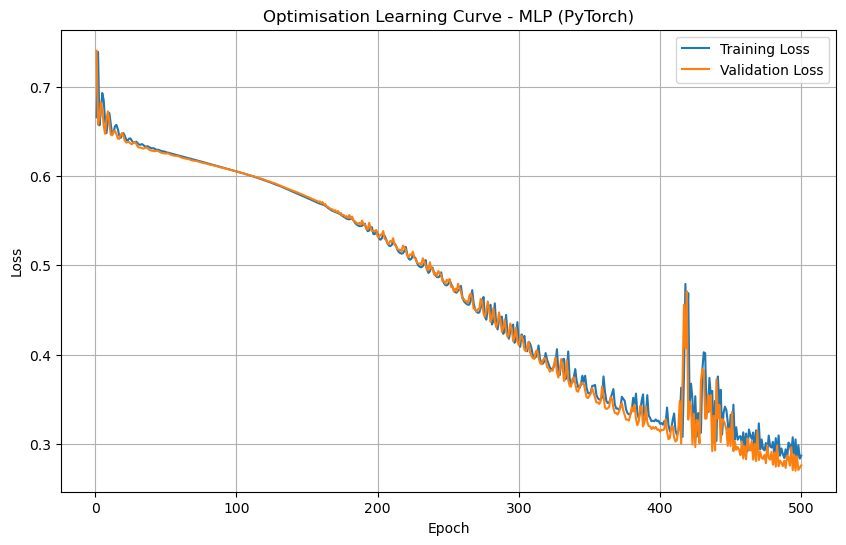

In [104]:
class nnClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        """
        Constructor for the neural network classifier.
        Initializes the layers and activation functions.

        """
        self.hiddenLayerOne = nn.Linear(in_features=57, out_features=75)
        self.activationOne = nn.ReLU()
        self.hiddenLayerTwo = nn.Linear(in_features=75, out_features=50)
        self.activationTwo = nn.ReLU()
        self.hiddenLayerThree = nn.Linear(in_features=50, out_features=25)
        self.activationThree = nn.ReLU()
        self.output = nn.Linear(in_features=25, out_features=1)
        self.activationOutput = nn.Sigmoid()

    def forward(self, x):
        """
        Forward pass of the neural network.

        @ x: Input data tensor

        @return: Output tensor
        """
        x = self.activationOne(self.hiddenLayerOne(x))
        x = self.activationTwo(self.hiddenLayerTwo(x))
        x = self.activationThree(self.hiddenLayerThree(x))
        x = self.activationOutput(self.output(x))
        
        return x

def trainModel(model, X_train, y_train, X_val, y_val, epochs=500, lr=1e-4, weight_decay=0.01):
    """
    Trains the neural network model.

    @ model: Neural network model
    @ X_train: Training data
    @ y_train: Training labels
    @ X_val: Validation data
    @ y_val: Validation labels
    @ epochs: Number of training epochs
    @ lr: Learning rate
    @ weight_decay: L2 regularization strength

    @ return: Tuple containing the best model's state dictionary, training losses, and validation losses
    """
    # Define the loss function
    loss_fn = nn.BCELoss()

    # Initialize the model and optimiser
    optimiser = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=weight_decay, eps=0.01)

    # Define things for later
    losses = []
    val_losses = []
    best_loss = float('inf')
    counter = 0

    for epoch in range(epochs):
        # Training loop
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        losses.append(loss.item())

        # Validation loss
        val_loss = loss_fn(model(X_val), y_val)
        val_losses.append(val_loss.item())

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            counter = 0
        else:
            counter += 1

        if counter > 35:
            print('-------------------------------------------')
            print(f'Early stopping after {epoch + 1} epochs and {counter} epochs of no improvement')
            print('-------------------------------------------')
            break
        else:
            if (epoch + 1) % 2 == 0:
                print(f'Finished epoch {epoch + 1}, latest loss {loss.item()}')

    return best_model, losses, val_losses

def crossValidation(X, y, n_splits=5, epochs=500, lr=0.001):
    """
    Perform k-fold cross-validation.

    @ X: Input data
    @ y: Labels
    @ n_splits: Number of folds
    @ epochs: Number of training epochs
    @ lr: Learning rate

    @return: Tuple containing the best models, all training losses, and all validation losses
    """

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    best_models = []
    all_train_losses = []
    all_val_losses = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Convert NumPy arrays to PyTorch tensors
        X_train = torch.FloatTensor(X_train)
        X_val = torch.FloatTensor(X_val)
        y_train = torch.FloatTensor(y_train)
        y_val = torch.FloatTensor(y_val)

        # Train the model
        print()
        best_model, train_losses, val_losses = trainModel(nnClassifier(), X_train, y_train, X_val, y_val, epochs=epochs, lr=lr)
        best_models.append(best_model)
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)

    return best_models, all_train_losses, all_val_losses

def learning_curve_plot(train_losses, val_losses):
    """
    Plot the learning curve.

    @ train_losses: List of training losses
    @ val_losses: List of validation losses
    """
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.grid()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Optimisation Learning Curve - MLP (PyTorch)')
    plt.legend()
    plt.show()

def model_evaluation(best_models, X_test, y_test):
    """
    Evaluate the model on the test set.

    @ best_models: List of best models
    @ X_test: Test data
    @ y_test: Test labels

    @ return: Tuple containing the best model, predictions, binary predictions, and the index of the best model
    """

    highest_accuracy = 0
    best_model = nnClassifier()

    for idx, model_state_dict in enumerate(best_models):
        # Create a new instance of the model
        current_model = nnClassifier()

        # Load the state dictionary into the current_model
        current_model.load_state_dict(model_state_dict)

        # Evaluate the model on the test set
        y_pred = current_model(X_test)

        # Convert predictions to binary (0 or 1) based on threshold, 0.5
        y_pred_binary = (y_pred > 0.5).float()

        # Calculate accuracy
        accuracy = torch.sum(y_pred_binary == y_test).item() / len(y_test)

        print(f'Model Accuracy: {accuracy * 100:.2f}%')

        if accuracy > highest_accuracy:
            highest_accuracy = accuracy
            y_pred_best = y_pred
            y_pred_binary_best = y_pred_binary
            best_model.load_state_dict(best_models[idx])
            best_model_idx = idx

    return best_model, y_pred_best, y_pred_binary_best, best_model_idx

# Convert NumPy arrays to PyTorch tensors
X_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)

# Perform cross-validation
best_models, all_train_losses, all_val_losses = crossValidation(X_train, y_train)

# Perform model evaluation 
best_model, y_pred_best, y_pred_binary_best, best_model_idx = model_evaluation(best_models, X_test, y_test)

# Plot the learning curve for the best model
learning_curve_plot(all_train_losses[best_model_idx], all_val_losses[best_model_idx])


## Learning Curve 

Roughly there are two types of learning curve, using different metrics:
- **Optimisation Learning Curves:** Learning curves calculated on the metric by which the parameters of the model are being optimized, e.g. loss.
- **Performance Learning Curves:** Learning curves calculated on the metric by which the model will be evaluated and selected, e.g. accuracy.

On learning curves, we have the two curves:
- **Train Learning Curve:** Learning curve calculated from the training dataset that gives an idea of how well the model is learning.
- **Validation Learning Curve:** Learning curve calculated from a hold-out validation dataset that gives an idea of how well the model is generalizing.


plot of learning curve shows **underfitting** if:
- the training loss remains flat regardless of training 
- the training loss continues to decrease until the end of training

plot of learning curve shows **overfitting** if:
- The plot of training loss continues to decrease with experience.
- The plot of validation loss decreases to a point and begins increasing again.


Resources
- https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/
- https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/
- https://www.sciencedirect.com/science/article/pii/S016981411100062X
- https://rstudio-conf-2020.github.io/dl-keras-tf/notebooks/learning-curve-diagnostics.nb.html

#### Confusion Matrix 

The confusion matrix is a matrix that summarises the performance of a machine learning model on a set of test data. 

- The top left represents the TP, true positive 
- The top right represents the FP - false positive 
- The bottom left represents the FN - false negative 
- The bottom right represents the TN - true negative 

Hence for a more accurate model, we expect the values in the FP and FN to be small

Pytorch Confusion Matrix Documentation - https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html

In [105]:
# Confusion Matrix - pytorch
from torchmetrics import ConfusionMatrix

confmat = ConfusionMatrix(task="binary", num_classes=2)
confmat(y_pred_binary_best, y_test)

tensor([[512,  19],
        [ 73, 317]])

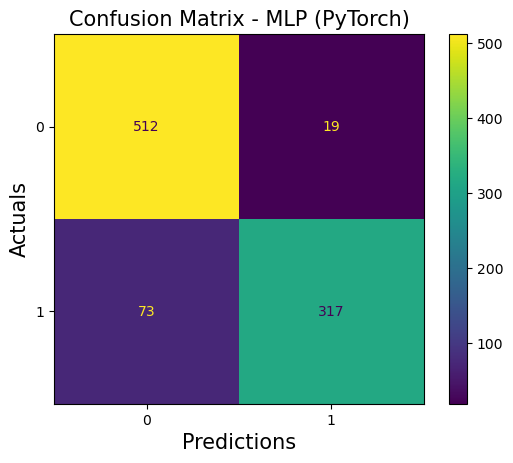

In [106]:
# Confusion Matrix - sklearn, only here because it is prettier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# convert y_test into a tensor of type torch.long
y_test_long = y_test.long()

confusion_matrix = confusion_matrix(y_true=y_test_long, y_pred=y_pred_binary_best)
conf_matrix = ConfusionMatrixDisplay(confusion_matrix)
conf_matrix.plot()
 
plt.xlabel('Predictions', fontsize=15)
plt.ylabel('Actuals', fontsize=15)
plt.title('Confusion Matrix - MLP (PyTorch)', fontsize=15)
plt.show()


#### ROC Curve (Receiver Operating Characteristic Curve)

This a graph showing the performance of a classification model at all classification thresholds, the curve plots two parameters 

1. True Positive Rate (TPR)

$$ TPR = \frac{\text{True Positives }}{\text{ True Positives } + \text{ False Negatives}} $$

2. False Positive Rate (FPR)

$$ FPR = \frac{\text{False Positives }}{\text{ False Positives } + \text{ True Negatives}} $$


Further Resources:
- https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

Pytorch Documentation  - https://torchmetrics.readthedocs.io/en/stable/classification/roc.html

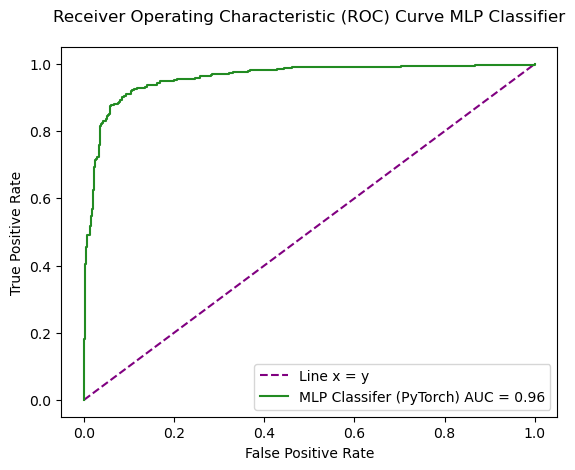

In [107]:
# CODE FOR ROC CURVE

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import RocCurveDisplay

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_best.detach().numpy())
roc_mlp = roc_auc_score(y_test, y_pred_best.detach().numpy())

# superimposed diagonal line for comparison
x_line = np.linspace(0, 1, 100)
plt.plot(x_line, x_line, label='Line x = y', color='purple', linestyle='--')
plt.plot(fpr, tpr, color='forestgreen', label=f'MLP Classifer (PyTorch) AUC = {roc_mlp:.2f}')

plt.title('Receiver Operating Characteristic (ROC) Curve MLP Classifier\n')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#### Area Under the ROC Curve (AUC)

The AUC measures the whole two-dimenstional area underneath the ROC curve, it ranges form 0.0 to 1.0
The provides a measure of performance across all classification thresholds. It can be 
interpreted as the probability that the model ranks a random positive example more highly that a random negative example
100% wrong would mean an AUC of 0.0 and 100% right would mean an AUC of 1.0. 

Two features of AUC are:

1. Scale Invariant
    + it measures how well predictions are ranked rather than their absolute values 
    - sometimes we need well calibrated probability outputs and the AUC will not tell us about this 

<p> <!-- Paragraph break --></p>

2. Classification- Threshold invariant:
    + it measures the quality of the model's predictions irrespective of what classification threshold is chosen 
    - this is not always desirable, especially in cases where there are wide disparities in the cost of false negative vs false positives. 

<p> <!-- Paragraph break --></p>

Further Resources:
- https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

Torchmetrics docs - https://torchmetrics.readthedocs.io/en/stable/classification/auroc.html#torchmetrics.functional.auroc


In [108]:
# CODE FOR AUC
from torchmetrics import AUROC

auroc = AUROC(task='binary')
float(auroc(y_pred_best, y_test))

0.9593220353126526

#### Matthews Correlation Coefficient (MCC) 

- The Matthews Correlation Coefficient (MCC) is a metri that takes into account all four values in the confusion matrix to 
provide a balanced measure of the classification performance 
- It ranges from -1 to 1, where 1 indicates a perfect prediction, 0 represents no better than random and -1 indicates total disagreement between prediction and observation
- Formula is given by:

$$ \text{MCC} = \frac{\text{TP} \times \text{TN} - \text{FP} \times \text{FN}}{\sqrt{(\text{TP} + \text{FP}) \times (\text{TP} + \text{FN}) \times (\text{TN} + \text{FP}) \times (\text{TN} + \text{FN})}} $$

Torchmetrics docs - https://torchmetrics.readthedocs.io/en/stable/classification/matthews_corr_coef.html

In [109]:
# CODE FOR MCC
from torchmetrics import MatthewsCorrCoef

matthews_corrcoef = MatthewsCorrCoef(task='binary')
float(matthews_corrcoef(y_pred_best, y_test))

0.7975810170173645

#### Cohen's Kappa

Cohen's Kappa is used to evaulate the agreement between the predicted and true class while account for the possibiilty of agreement occuring by chance. This is particularly useful for imbalanced datasets. It is calculated by:


$$\kappa = \frac{P_o - P_e}{1 - P_e}$$

Where:
- $P_o$ is the observed agreement
- $P_e$ is the expected agreement by chance.

Resources:
- https://en.wikipedia.org/wiki/Cohen%27s_kappa
- https://thenewstack.io/cohens-kappa-what-it-is-when-to-use-it-and-how-to-avoid-its-pitfalls/

Torch Metrics docs - https://torchmetrics.readthedocs.io/en/stable/classification/cohen_kappa.html#torchmetrics.CohenKappa

In [110]:
# CODE FOR Cohen Kappa
from torchmetrics import CohenKappa

cohenKappa = CohenKappa(task='binary')
float(cohenKappa(y_pred_best, y_test))

0.7915910482406616

## **Notes on the model**


- It seems to be very variable and can change a decent amount in different runs of the code